# Expkloring differences clinical decision making between high and low thrombolysing hospitals

## Plain English summary

It has become apparent that hospitals are making different clinical decisions, and it is not just the patient group that is accounting for the difference in thrombolysis rates between hosptials. Here we create two groups of hospitals: those that have a high propensity to thrombolyse, and those that have a low propensity to thrombolyse. Comparing the SHAP values between these two hospital groups shows that .... Trying to pick apart what factors the diff hospital groups are using to make their different decisions. 

low and high hosptials have same general pattern, but thrshoelds for it are different. Nothing dramatic about who they thrombolyse, just that less likely to thrombolyse across variaous categories. Are the NIHSS going to be pulled apart more in bootom than middle.

## Model and data

XGBoost models were trained on stratified k-fold cross-validation data. The 8 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke team: Stroke team attended
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (1 = Yes, 0 = No)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)

And one target feature:
* Thrombolysis: Recieve thrombolysis (1 = Yes, 0 = No)

The 8 features included in the model (to predict whether a patient will recieve thrombolysis) were chosen sequentially as having the single best improvement in model performance (using the ROC AUC). The stroke team feature is included as a one-hot encoded feature.

The Python library SHAP was applied to the first k-fold model to obtain a SHAP value for each feature, for each instance. SHAP values are in the same units as the model output, so for XGBoost this is in log odds-ratio.

A single SHAP value per feature was obtained by taking the mean of the absolute values across all instances.

## Aims:

* Identify top 30 and bottom 30 hosptials judged by the 10k cohort dataset
* Fit XGBoost model to each of the 5 k-fold train/test splits.
* Get SHAP values for the first k-fold split.
* Plot SHAP values for two features (NIHSS and mRS) for the top 30 and bottom 30 hospitals.

## Observations

* There was good consiency of SHAP values and importances across 5 k-fold replications.
* There was a reasonable correlation between SHAP and feature importance values, but also some differences in the rank order of importance.
    The five most influential features as judged by SHAP were:
    * Stroke type
    * Arrival-to-scan time
    * Stroke severity (NIHSS)
    * Stroke onset time type (precise vs. estimated)
    * Disability level (Rankin) before stroke
* The five most influential features (excluding teams) as judged by importance were:
    * Stroke type
    * Use of AF Anticoagulant
    * Stroke onset time type (precise vs. estimated)
    * Stroke severity (NIHSS)
    * Disability level (Rankin) before stroke
* Beeswarm, waterfall, and scatter plots all help elucidate the relationship between feature values and SHAP value.
* Plotting SHAP values as probabilities are more understandable than plotting as log odds-ratios, but can distort the relative importance of features overall.

#### For definitions see ***

### Note on shap version 0.40:

Installed using `pip install shap`

There is a bug in the waterfall plot where `show=False` (required to save plot) fails. To correct this find the `_waterfall.py` file in the shap library (e.g. in `anaconda/envs/samuel2/lib/python3.8/site-packages/shap/plots`, and search/replace all `pl.` to `plt.`, and replace initial import of `import matplotlib.pyplot as pl` with `import matplotlib.pyplot as plt`.

## Load packages

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import shap

from xgboost import XGBClassifier

import json

## Create output folders if needed

In [2]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [3]:
with open("./output/feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

FileNotFoundError: [Errno 2] No such file or directory: './output/feature_name_dict.json'

## Load data on predicted 10k cohort thrombolysis use at each hospital
Use the hospitals thrombolysis rate on the same set of 10k patients to select the 30 hospitals with the highest thrombolysis rates.

In [ ]:
thrombolysis_by_hosp = pd.read_csv(
    './output/10k_thrombolysis_rate_by_hosp_key_features.csv', index_col='stroke_team')
thrombolysis_by_hosp.sort_values(
    'Thrombolysis rate', ascending=False, inplace=True)

In [ ]:
thrombolysis_by_hosp.head()

Select the top 30 hospitals with highest thrombolysis rates for the common set of 10k patients. Store their stroke team name.

In [ ]:
top_30_hospitals = list(thrombolysis_by_hosp.head(30).index)
bottom_30_hospitals = list(thrombolysis_by_hosp.tail(30).index)

## Load SHAP data for first k-fold model
Use explainer to access the feature names (explainer.data_feature_names) and shap_values_extended to access the data values and SHAP values

In [ ]:
k = 0
filename = f'./output/shap_values_extended_xgb_key_features_{k}.p'
with open(filename, 'rb') as filehandler:
    shap_values_extended = pickle.load(filehandler)
    
filename = f'./output/shap_values_explainer_xgb_key_features_{k}.p'
with open(filename, 'rb') as filehandler:
    explainer = pickle.load(filehandler)

## Plot SHAP values for the top and bottom 30 hospitals
Put data into Dataframe. Select the 30 top and 30 bottom hospitals. Plot the SHAP values for the two features for the hospital groups.

In [ ]:
data_values_df = pd.DataFrame(shap_values_extended.data)
data_values_df.columns = explainer.data_feature_names
data_values_df

In [ ]:
#explainer.data_feature_names
shap_values_df = pd.DataFrame(shap_values_extended.values)
shap_values_df.columns = explainer.data_feature_names
shap_values_df

In [ ]:
features = ['Stroke severity', 'Prior disability level']

for feature in features:

    # Calculate data for top 30 hospitals
    shap_top_30 = pd.DataFrame()
    for hospital in top_30_hospitals:
        column_name = f"team_{hospital}"
        mask = data_values_df[column_name]!=0
        s1 = pd.Series(shap_values_df[feature][mask], name="shap")
        s2 = pd.Series(data_values_df[feature][mask], name="data")
        df = pd.concat([s1, s2], axis=1)
        shap_top_30 = shap_top_30.append(df)

    # calculate mean per category
    mean_by_category_top = shap_top_30.groupby('data').mean()

    # Calculate data for bottom 30 hospitals
    shap_bottom_30 = pd.DataFrame()
    for hospital in bottom_30_hospitals:
        column_name = f"team_{hospital}"
        mask = data_values_df[column_name]!=0
        s1 = pd.Series(shap_values_df[feature][mask], name="shap")
        s2 = pd.Series(data_values_df[feature][mask], name="data")
        df = pd.concat([s1, s2], axis=1)
        shap_bottom_30 = shap_bottom_30.append(df)
            
    # calculate mean per category
    mean_by_category_bottom = shap_bottom_30.groupby('data').mean()
        
    # plot means
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(111)
    ax1.scatter(mean_by_category_top.index,
                mean_by_category_top['shap'],
                label="top 30 hospitals")
    ax1.scatter(mean_by_category_bottom.index,
                mean_by_category_bottom['shap'],
                label="bottom 30 hospitals")
    ax1.set_xlabel(f'{feature}')
    ax1.set_ylabel('SHAP (mean of patients)')
    ax1.set_title('SHAP values for patients attending a low or high thrombolysing hospital')
    ax1.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    plt.show()

In [ ]:
shap_values_df

# As violinplot (... KP YOU ARE WORKING ON THIS)

You have the dataframe set up (a column per cateogroy (to use as a violin), with empty cells padded with NAN as not all categories have same number of points.

Following this suggestion: https://stackoverflow.com/questions/62278350/matplotlib-seaborn-violin-plots-for-different-data-sizes

But the violin plot isn't plotting.

For mRS only plotting 1 violin, for stroke severity plotting none. But have the full range of values on the x-axis.

Maybe this solution only works for seaborn, and not matplotlib?

In [11]:
feature = 'Prior disability level'#'Stroke severity'

# Calculate data for top 30 hospitals
shap_top_30 = pd.DataFrame()
for hospital in top_30_hospitals:
    column_name = f"team_{hospital}"
    mask = data_values_df[column_name]!=0
    s1 = pd.Series(shap_values_df[feature][mask], name="shap")
    s2 = pd.Series(data_values_df[feature][mask], name="data")
    df = pd.concat([s1, s2], axis=1)
    shap_top_30 = shap_top_30.append(df)

# each category will have different number ofpoints, so need to pad out the categories with fewer cases with NAN so same size
# put categories into separate series, and back in dataframe with NAN to pad out
violin_plot_dictionary = {}
for i in shap_top_30['data'].unique():
    mask = shap_top_30['data']==i
    s = pd.Series(shap_top_30['shap'][mask], name=f"{i}")
    violin_plot_dictionary[f'{i}'] = s

maxsize = max([a.size for a in violin_plot_dictionary.values()])
data_pad = {k:np.pad(v, pad_width=(0,maxsize-v.size,), mode='constant', constant_values=np.nan) for k,v in violin_plot_dictionary.items()}
violin_df = pd.DataFrame(data_pad)
violin_df

,0.0,3.0,5.0,1.0,4.0,2.0
0,0.461281,-0.321622,-1.158636,-0.069477,-0.694905,-0.385744
1,0.329546,-0.561425,-0.939278,-0.008170,-1.173281,-0.360862
2,0.482051,-0.480900,-0.914171,-0.077072,-1.019824,-0.343827
3,0.597126,-0.738885,-1.152894,-0.087525,-0.872040,-0.433209
4,0.552977,-0.412180,-1.030015,-0.119054,-0.934156,-0.266986
...,...,...,...,...,...,...
2467,0.392699,NaN,NaN,NaN,NaN,NaN
2468,0.539439,NaN,NaN,NaN,NaN,NaN
2469,0.235586,NaN,NaN,NaN,NaN,NaN
2470,0.609330,NaN,NaN,NaN,NaN,NaN


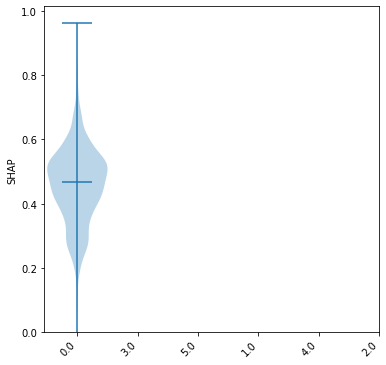

In [12]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(violin_df,
              showmedians=True,
              widths=1)
ax1.set_ylim(0)
labels = list(violin_df)
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
#ax1.grid(which='both')
ax1.set_ylabel('SHAP')
#plt.savefig('output/violin_shap_between_low_high.jpg', dpi=300, 
#            bbox_inches='tight', pad_inches=0.2)
plt.show()

# When ready put workign code here

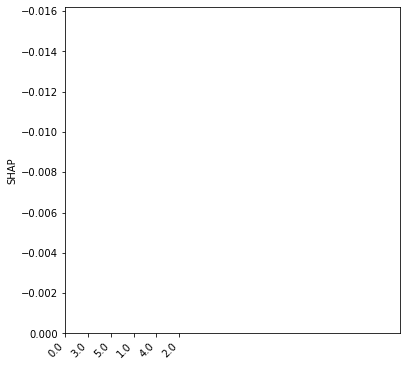

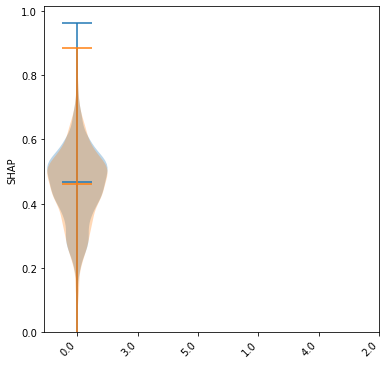

In [13]:
features = ['Stroke severity', 'Prior disability level']

for feature in features:

    # Calculate data for top 30 hospitals
    shap_top_30 = pd.DataFrame()
    for hospital in top_30_hospitals:
        column_name = f"team_{hospital}"
        mask = data_values_df[column_name]!=0
        s1 = pd.Series(shap_values_df[feature][mask], name="shap")
        s2 = pd.Series(data_values_df[feature][mask], name="data")
        df = pd.concat([s1, s2], axis=1)
        shap_top_30 = shap_top_30.append(df)

    # each category will have different number ofpoints, so need to pad out the categories with fewer cases with NAN so same size
    # put categories into separate series, and back in dataframe with NAN to pad out
    violin_plot_dictionary = {}
    for i in shap_top_30['data'].unique():
        mask = shap_top_30['data']==i
        s = pd.Series(shap_top_30['shap'][mask], name=f"{i}")
        violin_plot_dictionary[f'{i}'] = s

    maxsize = max([a.size for a in violin_plot_dictionary.values()])
    data_pad = {k:np.pad(v, pad_width=(0,maxsize-v.size,), mode='constant', constant_values=np.nan) for k,v in violin_plot_dictionary.items()}
    violin_top_df = pd.DataFrame(data_pad)
    

    # Calculate data for bottom 30 hospitals
    shap_bottom_30 = pd.DataFrame()
    for hospital in bottom_30_hospitals:
        column_name = f"team_{hospital}"
        mask = data_values_df[column_name]!=0
        s1 = pd.Series(shap_values_df[feature][mask], name="shap")
        s2 = pd.Series(data_values_df[feature][mask], name="data")
        df = pd.concat([s1, s2], axis=1)
        shap_bottom_30 = shap_bottom_30.append(df)
            
    # each category will have different number ofpoints, so need to pad out the categories with fewer cases with NAN so same size
    # put categories into separate series, and back in dataframe with NAN to pad out
    violin_plot_dictionary = {}
    for i in shap_bottom_30['data'].unique():
        mask = shap_bottom_30['data']==i
        s = pd.Series(shap_bottom_30['shap'][mask], name=f"{i}")
        violin_plot_dictionary[f'{i}'] = s

    maxsize = max([a.size for a in violin_plot_dictionary.values()])
    data_pad = {k:np.pad(v, pad_width=(0,maxsize-v.size,), mode='constant', constant_values=np.nan) for k,v in violin_plot_dictionary.items()}
    violin_bottom_df = pd.DataFrame(data_pad)
        
    # plot violins
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(111)
    ax1.violinplot(violin_top_df,
                  showmedians=True,
                  widths=1)#'
#                  label="top 30 hospitals")
    ax1.violinplot(violin_bottom_df,
                  showmedians=True,
                  widths=1)#,
#                  label="bottom 30 hospitals")
    ax1.set_ylim(0)
    labels = list(violin_df)
    ax1.set_xticks(np.arange(1, len(labels) + 1))
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    #ax1.grid(which='both')
    ax1.set_ylabel('SHAP')
    #plt.savefig('output/violin_shap_between_low_high.jpg', dpi=300, 
    #            bbox_inches='tight', pad_inches=0.2)
    plt.show()